# Objectives

In this note book, i generate multiple sources ( 2 so far) and run Nested sampling.

In [1]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Generate Many sources

### TODO: Define Gaussian shaped function

$$\tau(X,Y,A,R) = A\exp{[-\frac{(x-X)^{2} + (y-Y)^{2}}{2R^{2}}]}$$

### the above equation is used to model each source.

In [2]:
def Template_Equation(theta,params):
    """ Returns Gaussian shaped Function
    
    Parameters
    
    ---------------------
    
    theta : list,array
            List of parameters X , Y and A.
            
    params: list,array
            x,y - row by coloumn pix
    ---------------------- 
    
    output: Dataset
            pix by pix model
    """
    x,y = params
    X,Y,A = theta
    R = 3
    template = A*np.exp(-(((x-X)**2 + (y-Y)**2)/(2*R**2)))
    return template

In [5]:
def adds_Multiple_Sources(theta):
    """This function returns an addition of the *models*
    
    Parameters:
    ---------------
    
    model : Function , ()
            single model equation
            
    model_params: list,array  (params)
            parameters of the model
            
    ------------------        
    output: Dataset
            Addition of models [pix by pix]
    """
    s1 , s2 = theta
    
    Model = Template_Equation(s1,[x,y]) + Template_Equation(s2,[x,y])
    return Model 

# Prior on [X,Y,A]

TODO : Define functions of the prior probability on X , Y and A,

The prior probabilities on X and Y are flat priors definied by.
                
$$P(X) = \frac{1}{X_{upper}-X_{lower}}$$
$$P(Y) = \frac{1}{Y_{upper}-Y_{lower}}$$
                    
and the prior on A is an exponential prior.
                        $$P(A) = \exp{(-A)}$$

In [4]:
def LogPrior(theta,theta_limits):
    """Evaluate the prior probability of each X,Y and A
    
    Parameters
    
    ----------------
    
    theta : list,array
            [X,Y,A] parameters to be evaluated
            
    theta_limits: list,array 
            The limits of X,Y and A.
    
    ----------------
     output: scalar
            The log Prior of X,Y and A.
    
    """
    
    log_X_prior = 0
    log_Y_prior = 0 
    log_A_prior = 0
    for i in range(num_of_sources):
        theta_source = theta[i]
    
        X,Y,A = theta_source
        Xlimits,Ylimits = theta_limits
    
        if (X < Xlimits[0]) | (X > Xlimits[1]):
            log_X_prior += -np.inf
        else:
            log_X_prior += np.log(1.0/(Xlimits[1] - Xlimits[0]))
        
        if (Y < Ylimits[0]) | (Y > Ylimits[1]):
            log_Y_prior += -np.inf
        else:
            log_Y_prior += np.log(1.0/(Ylimits[1] - Ylimits[0]))
    
        if (A<0):
            log_A_prior += -np.inf
        else:
            log_A_prior += np.log(np.exp(-A))
    
    return log_X_prior + log_Y_prior + log_A_prior

# Likelihood

TODO: I define a Gaussian log-likelihood function given by;

$$\log{L} = \sum_{i}^{n}{\log{(\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}})} + \sum_{i}^{n}{-\frac{(data - model)^{2}}{2\sigma_{i}^{2}}}$$

In [6]:
def LogL(model,theta,data,sigmay):
    '''
    Returns the log-likelihood the of the model given Gaussian measurement noise with standard
    deviation with known *sigmay*, where "y_data" is the known data values 
    
    Parameters
    
    ----------------
    
    model : Function
            Model function
    theta: list,array
            model parameters [X,Y,A]
    
    data : matrix
            Image data
    sigmay : matrix
            each pixel noise (Gaussian noise)
    
    ----------------
    Output: scalar
            log likelihood
    '''
    
    y_data = data
    model = adds_Multiple_Sources(theta)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y_data - model)**2 / sigmay**2))
    return logL

# Generate walkers

In [7]:
def Get_particles_from_prior():   # Sampling from the prior space
    """Sample X,Y and A parameters from prior space
    
    """
    
    theta = []
    for i in range(num_of_sources):
        X = sp.stats.uniform.rvs(0,npix)
        Y = sp.stats.uniform.rvs(0,npix)
        A = sp.stats.uniform.rvs(5,20)
        theta.append([X,Y,A])
    
    return theta

# Simulate Multiple Sources

In [10]:
npix = 80             #Pixel size
num_of_sources = 2    #Number of sources

x = np.arange(0, npix, 1, float)
y = x[:,np.newaxis]


#Locations ,Spatial extent and Flux
X = 25
Y = 25
A = 15

X1 = 45
Y1 = 45
A1 = 15

theta_sources = [[X,Y,A],[X1,Y1,A1]]

#Gaussian Noise
noise_sigma = 1.0
Noise = np.random.normal(0,noise_sigma,(npix,npix))

# Image data
    
Img_data = adds_Multiple_Sources(theta_sources) + Noise

Text(0,0.5,'Arbitrary Flux')

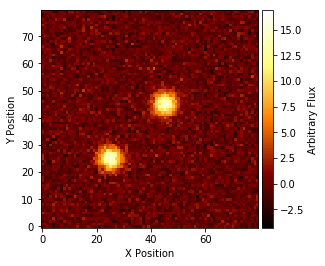

In [11]:
ax = plt.subplot(111)
im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


# Simulated Image
plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

In [66]:
#Generate walkers

#Number of walkers
N = 550

particles = []
logp = np.empty(N)
logl = np.empty(N)

#Data and Noise 
data = Img_data
sigmay = Noise

#parameter limits
Xlimits = [0.0, npix]
Ylimits = [0.0,npix]
theta_limits = (Xlimits, Ylimits)

# Generate walkers
for i in range(0, N):
    
    # Generate each source [X,Y,A]
    theta = Get_particles_from_prior()
    particles.append(theta)              #Save each sample
    
    model = adds_Multiple_Sources(theta)
    logl[i] = LogL(model,theta,data,sigmay)    # Save Likelihood of each sample
    logp[i] = LogPrior(theta,theta_limits)      #Save prior prob of each sample

# Initialize

In [67]:
# Number of NS iterations
nest_steps = 25000

# MCMC steps per NS iteration
mcmc_steps = 60

# mcmc stepsize
Xstep , Ystep , Astep ,Xstep1 , Ystep1 , Astep1  = 0.01,0.03,0.01, 0.01,0.02,0.01
stepsize = np.array([[Xstep,Ystep,Astep],[Xstep1 , Ystep1 , Astep1]])

#Number of parameters
num_params = 3



# Storage for results
keep = np.zeros((nest_steps,num_params,num_of_sources+1)) # np.empty((nest_steps, num_params,num_of_sources+1))

nacceptance = np.zeros(nest_steps)
nrejectance = np.zeros(nest_steps)

In [68]:
for i in range(nest_steps):
    
    worst = np.argmin(logl)   # Particle with worst likelihood
    
    keep[i,:-1] = particles[worst] # Save the details of the worst particle , (m,c) and (likelihood)
    keep[i,-1][0] = logl[worst]
    
    # Copy random survivor
    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(particles))
        if (copy != worst):break
            
    particles[worst] = duplicate.deepcopy(particles[copy]) # Throw away worst particle and replace with random particle 
                                                            #and do mcmc from the random particle (will change with new sample)
    
    logl_threshold = duplicate.deepcopy(logl[worst])    # Likelihood of worst point
    
    naccept = 0      #count number of accepted samples
    nreject = 0     #count number of rejected samples
    for mcmci in range(mcmc_steps):   # Do mcmc on the random survivor
        theta_new = particles[worst] + stepsize * np.random.randn(2,3)  #Generate new sample
        logl_new = LogL(model,theta_new,data,sigmay)

        #Likelihood of new sample
        
        logp_new = LogPrior(theta_new,theta_limits)                           #prior prob of new sample
        
        if (logl_new>logl_threshold) and (logp_new-logp[worst])>=np.log(np.random.rand()): #Accept new sample
            particles[worst] = theta_new                                #replace worst sample with new sample
            logp[worst] = logp_new                                      # replace worstp with newp of new sample
            logl[worst] = logl_new                                      #replace worstL with newL of new sample
            
            naccept += 1                                              #increment number of accepted sample 
            
        else: # otherwise reject new sample 
            particles[worst] = particles[worst]     #stay at current position and look for new sample again
            nreject += 1
    
    nacceptance[i] = naccept/mcmc_steps #evaluate mcmc acceptance ratio



#Prior Mass    
logX = -(np.arange(0, (nest_steps))+ 1.)/N  # evalute prior mass

Text(0,0.5,'Acceptance Ratio')

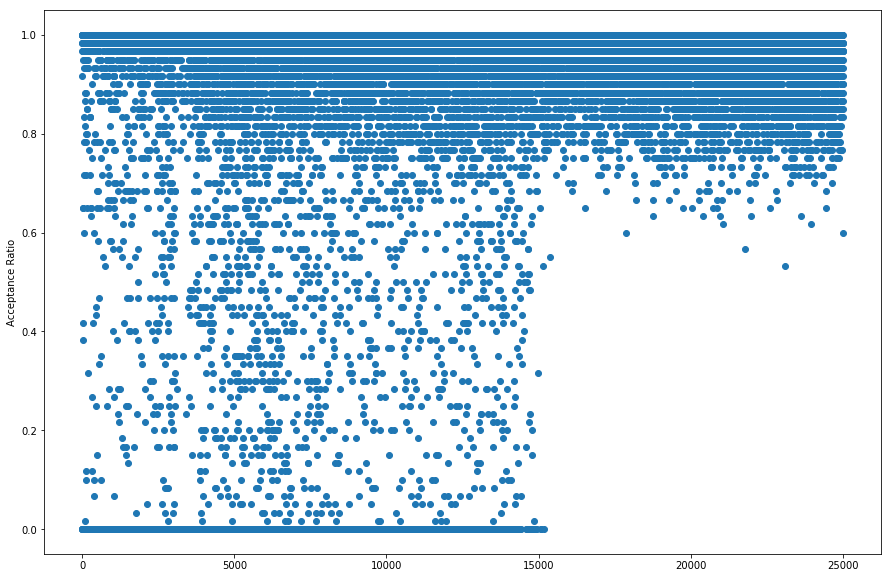

In [69]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$\\log(X)$')

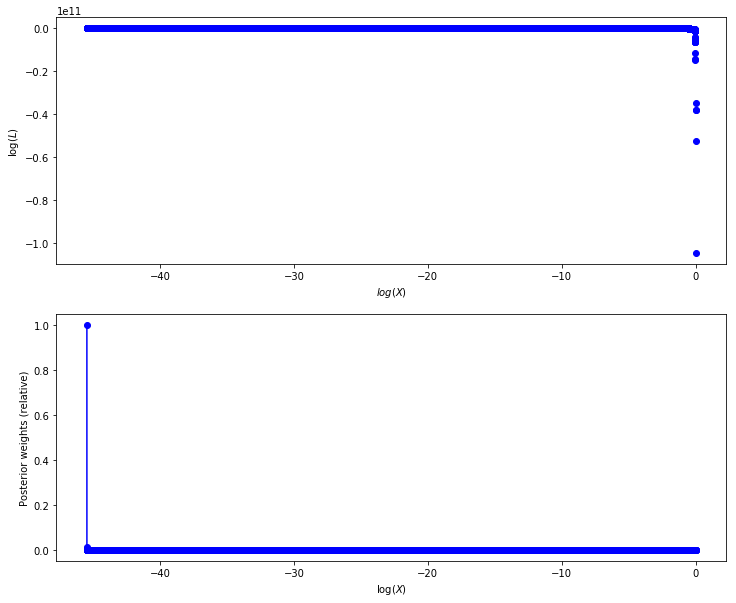

In [70]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(logX, keep[0:(nest_steps), -1][:,0], 'bo')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)

#Posterior weights

logwt = logX.copy() + keep[0:(nest_steps), -1][:,0]

wt = np.exp(logwt - logwt.max())              # Normalised posterior weights
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [71]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result



# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1][:,0])

# Normalised posterior weights
wt = wt/wt.sum()

effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1][:,0] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -557198.7060257741 
Information = 51.710362695670554
Effective Sample Size = 1


In [72]:
posterior_samples = np.empty((effective_sample_size, 3,3))
logX_effective = np.empty(effective_sample_size)
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        logX_effective[k] = logX[k]
        k += 1

    if k >= effective_sample_size:
        break

#np.savetxt('keep_Many.txt', posterior_samples)

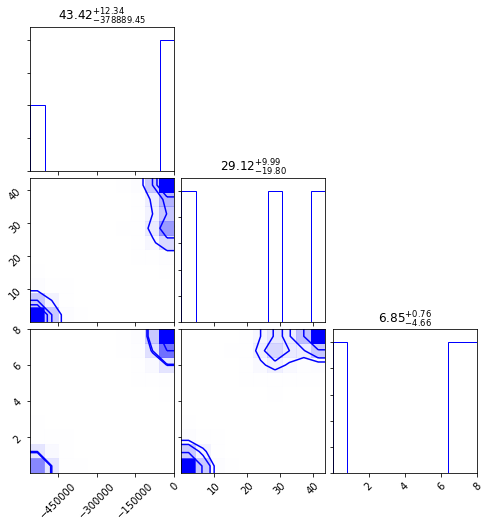

In [73]:
Fig = corner.corner(posterior_samples[0],bins=10,show_titles=True,color='b',smooth=1.0);